In [ ]:
! pip install emoji

In [ ]:
import emoji
import numpy as np
import pandas as pd
import re
import spacy
import string
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

## **Data Preprocessing**

Please follow the instructions in the link below where you download your API credentials from your Kaggle profile and upload the credentials stored in `kaggle.json` into this notebook. Next, run the code in the cell below. You should be able to access the dataset from then onwards.

https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# import the raw data
! kaggle datasets download danofer/sarcasm
! unzip sarcasm

 92% 200M/216M [00:02<00:00, 118MB/s]
100% 216M/216M [00:02<00:00, 105MB/s]
Archive:  sarcasm.zip
  inflating: test-balanced.csv       
  inflating: test-unbalanced.csv     
  inflating: train-balanced-sarc.csv.gz  
  inflating: train-balanced-sarcasm.csv  


In [ ]:
# import intermediate features extracted using the code below
! kaggle datasets download chenyiyang/reddit-sarcasm-extracted-features-dataset
! unzip reddit-sarcasm-extracted-features-dataset

 35% 5.00M/14.2M [00:00<00:00, 51.5MB/s]
100% 14.2M/14.2M [00:00<00:00, 69.5MB/s]
Archive:  reddit-sarcasm-extracted-features-dataset.zip
  inflating: X-test-v1.0.csv         
  inflating: X-train-v1.0.csv        
  inflating: y-test-v1.0.csv         
  inflating: y-train-v1.0.csv        


The following changes were made to the data as part of preprocessing:
*   Removed rows that have an empty string as the comment

In [ ]:
df = pd.read_csv('train-balanced-sarcasm.csv')

# Remove empty comments
df['comment'].replace('', np.nan, inplace=True)
df.dropna(subset=['comment'], inplace=True)

df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc13d521810>,
      dtype=object)

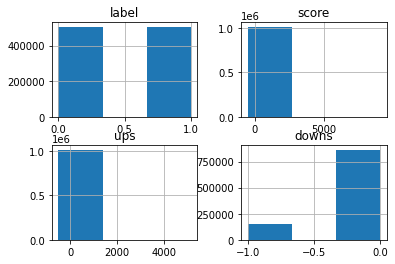

In [ ]:
df.hist(bins=3)

In [ ]:
# Split data into train and test sets
df_X = df[df.columns[df.columns != 'label']].copy()
df_y = df['label'].copy()
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=0)
print("Number of training instances: ", len(X_train), "\nNumber of test instances: ", len(X_test))

Number of training instances:  808618 
Number of test instances:  202155


### Dataset Exploration
**Questions to Consider**
- See if a parent comment is shown as the comment in another row in the dataset ("a thread")
- See if such parent comments exist then whether they are sarcastic or not

First find overlaps between the two columns of comments.
Then sieve out the "invalid" threads such as 
- "!RemindMe 1 Year"
- "!YeetMe 1YeetDay"
- or "#triggered" 

that people tend to comment the same thing following one another everywhere.

Here are the conditions that (I suppose) can help find valid comment - parent comment pairs:
- are in the same `subreddit`

  rationale: in different subreddit, then definitely not replying to one another.

- is 1-1 relationship

  rationale: so that it will not be same common phrases that people comment everywhere (even if in same subreddit)

- have comment length >= 10 (or 20) characters

  rationale: try to avoid short phrases that people comment but does not contribution to discussion.


In [ ]:
# Preliminary filtering
comments_data = df['comment']
parent_comments_data = df['parent_comment']

commons = np.intersect1d(comments_data, parent_comments_data)
#comments_data[np.in1d(comments_data, parent_comments_data)]

In [ ]:
total_valid = 0
MIN_COMMENT_LEN = 10;
valid_comments = []

for i in range(len(commons)):
  if (i % 500 == 0):
    print("i = ", i)

  common = commons[i]

  # Check length
  if len(common) < MIN_COMMENT_LEN:
    continue
  
  # check mapping
  comment_res = np.where(comments_data == common)[0]
  parent_res = np.where(parent_comments_data == common)[0]
  if (len(comment_res) != 1 or len(parent_res) != 1):
    continue
  
  comment_id = comment_res[0]
  parent_id = parent_res[0]

  if (comment_id == parent_id):
    continue

  # check same subreddit 
  if (df['subreddit'][comment_id] != df['subreddit'][parent_id]):
   continue
  
  total_valid += 1
  valid_comments.append(common)

print("total valid = ", total_valid)

In [ ]:
len(commons)
total_valid
valid_comments

#### Result
when limit to comments of length >= 10, 39 of them considered valid.

when limit to comments of length >= 20, 18 of them considered valid.

In [ ]:
displayed = 0
for common in commons:
  if (len(common) < 20):
    continue

  res_in_comments = np.where(comments_data == common)[0]
  res_in_parents = np.where(parent_comments_data == common)[0]


  if (len(res_in_comments) > 1):
    continue
  
  if (len(res_in_comments) == 1 and len(res_in_parents) == 1):
    displayed += 1
    

    first_print = True
    i_comment = res_in_comments[0]
    if (df['comment'][i_comment] == df['parent_comment'][i_comment]):
      continue

    for i in res_in_parents:
      if (i == i_comment):
        continue
      if (df['comment'][i] == df['parent_comment'][i]):
        continue

      with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        if (first_print):
          print("---------------" + "Common word: " + common + "----------")
          print("################ Look Comment ################")
          print(df[i_comment:i_comment+1])
          first_print = False
          displayed +=1
          print("############# Look Parent Comment #############")
        print(df[i:i+1])
        print("\n\n")

    if (displayed >= 100):
      break

## **Feature Extraction**

### Curated Features

Alternatively, we can manually extract selected features from the data and create our own feature vector. Let's extract the features based on the pseudocode (Algorithm 2) provided in the paper below. The paper extracts a total of 20 features: 

- [X] Noun and verb count
- [X] Positive intensifier, negative intensifier
- [X] Bigram, trigram, skip gram, unigram
- [X] Emoji sentiment
- [X] Sentiment score
- [X] Interjections
- [X] Punctuators, exclamations, question mark
- [X] Uppercase
- [X] Repeat words count
- [X] Positive word frequency, negative word frequency
- [X] Polarity flip
- [X] Parts of speech tagging

https://www.hindawi.com/journals/cin/2020/2860479/


In [ ]:
sid = SentimentIntensityAnalyzer()
word_tokenizer = RegexpTokenizer(r'\w+') # ignores punctuations

In [ ]:
def intesifier_improved(text):
  # We might use this function in future
  # If we find a corpus of all English intensifiers
  exclude = set(string.punctuation)
  intensifier_list = []
  tokens = text.split()
  int_count = 0
  neg_int_c = 0
  pos_int_c = 0
  for word in tokens: 
    score = sid.polarity_scores(word)
    if word in intensifier_list:
      int_count += 1
      if score['neg']:
        neg_int_c += 1
      elif score['pos']:
        pos_int_c += 1
    return int_count, neg_int_c, pos_int_c

#### Emoji / Emoticon Sentiments

I'm not sure if we should convert emoticon to text and then replace in the comment, or we should extract emoticons out of the comment and treat it as like a separate feature. When converting emojis, there's multiple ways too.

1. Convert the text form of an emoticon to a sentiment value (`+1` or `-1`): `smiley cool playful surprised love` = `+1`; `sad worried crying` = `-1`
2. Or consider each emotion (`smiley`, `cool`, `playful`, etc.) as a "classification type" on its own so can leave it in word form or assign number to it so it becomes a vector: `smiley` = 1, `cool` = 2, etc

So I implemented it both ways. The `convert_emoticons` function replaces all the emoticons in a comment to their word forms. The `sentiment emoticon` function extracts all the emoticons, changes them to their sentiment value, and returns the **product** of all its sentiment values.

In [ ]:
# This might suffice for now, but in future we should use a dataset of emojis
smilies = {":-)": "smiley", ":)": "smiley", ":D": "smiley", "xD": "smiley", 
     ":’)": "smiley", ":’D": "smiley", ":3": "smiley", ":]": "smiley", 
     ":^)": "smiley", ":-]": "smiley", ":-3": "smiley", ":->": "smiley", 
     ":))": "smiley", ":-}": "smiley", ":>": "smiley", ":}": "smiley", 
     ":o)": "smiley", ":c)": "smiley", "=)": "smiley", "=D": "smiley",
     "=]": "smiley", ":-D": "smiley", "XD": "smiley", "8-)": "cool", 
     "8)": "cool", "8-D": "cool", "B)": "cool", "BD": "cool", ":P": "playful", 
     ":p": "playful", "xP": "playful", "XP": "playful", "=P": "playful", 
     "=p": "playful", "xp": "playful", "xb": "playful", "❤": "love",
     ":o": "surprised", ":O": "surprised", "=o": "surprised", "=O": "surprised",
     ":0": "surprised", ":(": "sad", ":C": "sad", ":c": "sad", "=(": "sad", 
     "=c": "sad", "=C": "sad", ":-(": "sad", ":-c": "sad", ":-C": "sad", 
     ":-<": "sad", ":<": "sad", ":[": "sad", ":{": "sad", "</3": "sad", 
     ":’(": "crying", ":/": "worried", ":-/": "worried"}

emot_to_sentiment = {"smiley": 1, "cool": 1, "playful": 1, "surprised": 1, 
                     "love": 1, "sad": -1, "worried": -1, "crying": -1}

# Replaces emoticon in a comment in word form 
def convert_emoticons(comment):
  split_comment = comment.split(" ")
  for key,val in smilies.items():
    if key in comment:
      new_comment = comment.replace(key, val)
      comment = new_comment
  return (comment,)

# Extracts all emoticons in a comment and stores it in text form 
def extract_emoticons(comment):
  split_comment = comment.split(" ")
  emoticon = []
  haveEmoticon = False
  for key,val in smilies.items():
    if key in comment:
      haveEmoticon = True
      emoticon.append(val)
  if haveEmoticon:
    return tuple(emoticon)
  else:
    return ("none",)

# Extracts the emoticons, changes each to sentiment value
# Gets the product of all the emoticon sentiment value in a comment
def sentiment_emoticon(comment):
  split_comment = comment.split(" ")
  haveEmoticon = False
  emoticon = []
  for key,val in smilies.items():
    if key in comment:
      haveEmoticon = True
      emoticon.append(emot_to_sentiment[val])
  if haveEmoticon:
    return (np.sum(emoticon))
  else:
    return (0)

text = "It is so funny I could cry. :D :( :D :D :P It is hilariously sad"
sentiment_emoticon(text)

1

#### Overall Feature Vector

In [ ]:
def to_feature_vector(x):
  tokens = nltk.word_tokenize(x)
  tagged_tokens = np.array(nltk.pos_tag(tokens))

  # Noun and Verb Count
  noun_count = sum([tt[1] in ['NN', 'NNS', 'NNP', 'NNPS'] for tt in tagged_tokens])
  verb_count = sum([tt[1] in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'] for tt in tagged_tokens])

  # Positive and Negative Words, and Polarity Flip
  pos_count = 0
  neg_count = 0
  flip_count = 0
  word_tokens = word_tokenizer.tokenize(x)
  for i in range(len(word_tokens)):
    if sid.polarity_scores(word_tokens[i])['compound'] > 0:
        pos_count += 1
    else:
        neg_count += 1
    if i - 1 >= 0:
      if sid.polarity_scores(word_tokens[i - 1])['compound'] < 0:
        flip_count += 1
  
  # Compound Sentiment Score
  sentiment_score = sid.polarity_scores(x)['compound']

  # Punctuation
  exclam_count = x.count('!')
  quest_count = x.count('?')

  # Uppercase
  upper_count = sum(word.isupper() for word in word_tokens)

  # Repeated Letters (at least 3 consecutive)
  repeat_count = len(re.compile(r'(.)\1{2,}').findall(x))
  
  # Interjections
  inter_count = sum([tt[1] == 'UH' for tt in tagged_tokens])

  # ngrams
  # unigrams = list(nltk.ngrams(text.split(), 1))
  # bigrams = list(nltk.ngrams(text.split(), 2))
  # trigrams = list(nltk.ngrams(text.split(), 3))

  # skip grams
  # n = 2
  # k = 3
  # skip_grams = list(nltk.skipgrams(text.split(), n, k))

  # Intensifier Sentiment
  inten_count = sum([tt[1] in ['RB', 'RBR', 'RBS'] for tt in tagged_tokens])
  pos_inten = 0
  neg_inten = 0
  for i in range(len(tagged_tokens)):
    if tagged_tokens[i][1] in ['RB', 'RBR', 'RBS']:
      if sid.polarity_scores(tokens[i])['compound'] > 0:
        pos_inten += 1
      else:
        neg_inten += 1
  
  # Emoticon Sentiment
  emot = sentiment_emoticon(x)

  return noun_count, verb_count, pos_count, neg_count, flip_count, exclam_count, quest_count, upper_count, repeat_count, inter_count, inten_count, pos_inten, neg_inten, emot, sentiment_score

print(to_feature_vector("I love Machine Learning! I am totally not going to totally fail! WOOHOO!"))
print(to_feature_vector("This is a serious sentence. It is not a sarcastic sentence."))
print(to_feature_vector("OMG???? ARE YOU SERIOUS????? I AM SOOOO STOKED! :D :D"))

In [ ]:
x = "Yeah, what a totalitarian hellhole."
intesifier_improved(x)

(0, 0, 0)

## **Model Selection**

### Preparation
Run the feature extraction code to get the features for the training and testing data

Alternatively, read from csv files for the features obtained from previous sessions.


In [ ]:
to_feature_matrix = np.vectorize(to_feature_vector)

In [ ]:
X_train_features = np.array([to_feature_vector(x) for x in X_train['comment']])
y_train = y_train[:10000]
X_test_features = np.array([to_feature_vector(x) for x in X_test['comment']])
y_test = y_test[:10000]

KeyboardInterrupt: ignored

In [ ]:
VERSION_STR = '-v1.0' # lol idk if need this
X_TRAIN_STR = 'X-train' + VERSION_STR + ".csv"
y_TRAIN_STR = 'y-train' + VERSION_STR + ".csv"
X_TEST_STR = 'X-test' + VERSION_STR + ".csv"
y_TEST_STR = 'y-test' + VERSION_STR + ".csv"

np.savetxt(X_TRAIN_STR, X_train_features, delimiter=',')
np.savetxt(y_TRAIN_STR, y_train, delimiter=',')
np.savetxt(X_TEST_STR, X_test_features, delimiter=',')
np.savetxt(y_TEST_STR, y_test, delimiter=',')

#### Load Features from Files
Run this part of code to load instead of running the code to get the features

In [ ]:
X_train_features = np.genfromtxt("X-train-v1.0.csv", delimiter=',')
y_train = np.genfromtxt("y-train-v1.0.csv", delimiter=',')
X_test_features = np.genfromtxt("X-test-v1.0.csv", delimiter=',')
y_test = np.genfromtxt("y-test-v1.0.csv", delimiter=',')
y_train.shape

(10000,)

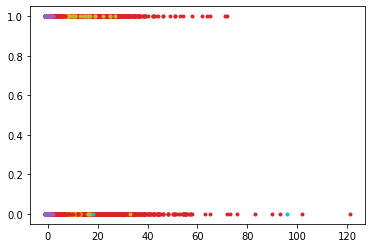

In [ ]:
#to plot
from matplotlib import pyplot as plt
plt.plot(X_train_features[:10000],y_train,".")

In [ ]:
X_test_features.shape

(808618,)

## N-Gram Vectors

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 3)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.

    # Returns
        x_train: vectorized training texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams + 3-grams.
            'dtype': np.float64,
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    return x_train

x_train = ngram_vectorize(X_train['comment'][:10000], y_train);
print(x_train)

### Logistic Regression
Perform logistic regression:
- on tokenised comment data (not in this notebook)
- on the features extracted


In [ ]:
from sklearn.linear_model import LogisticRegression

logisticRegression = LogisticRegression()

# def
train_size = len(X_train_features)  # tried 10k first then use all
test_size = len(X_test_features)

# train
X_train_lr = X_train_features[:train_size]
y_train_lr = y_train[:train_size]
X_test_lr = X_test_features[:test_size]
y_test_lr = y_test[:test_size]

logisticRegression.fit(X_train_lr, y_train_lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# test
score_lr = logisticRegression.score(X_test_lr, y_test_lr)
print("Accuracy:", score_lr)

predict_lr = logisticRegression.predict(X_test_lr)
print("ROC-AUC:", roc_auc_score(y_test_lr, predict_lr))

Accuracy: 0.5726447527887017
ROC-AUC: 0.5724314744770053
